In [7]:
import os
import pandas as pd 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py

In [35]:
dataset_name = "dartmouth" # fer, dartmouth

In [36]:
df = pd.read_csv(f"../data/{dataset_name}/{dataset_name}48x48.csv")
df.head()

,emotion,pixels
0,3,11 10 10 11 11 10 11 11 12 11 11 11 11 11 11 1...
1,0,73 75 73 73 69 73 73 69 72 78 79 94 101 97 92 ...
2,6,60 58 58 59 59 59 59 60 58 58 58 57 55 52 50 4...
3,3,10 10 10 11 10 11 10 11 12 11 10 10 11 11 11 1...
4,3,53 52 51 52 53 52 53 53 55 56 57 58 57 58 55 5...


In [37]:
def preprocess_pixels(data: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    """
    Converts the 'pixels' column in the DataFrame from strings to NumPy arrays
    and normalizes the pixel values to be between 0 and 1. The shape of the array
    is determined by the dataset_name.
    
    Parameters:
    - data: DataFrame containing a 'pixels' column with pixel data in string format.
    - dataset_name: The name of the dataset, which determines the reshaping.
    
    Returns:
    - DataFrame with the 'pixels' column containing normalized NumPy arrays.
    """
    def process_pixel(pixel):
        pixel_array = np.array(pixel.split(), dtype=np.uint8)
        if dataset_name == "dartmouth":
            pixel_array = pixel_array.reshape((3, 48, 48))
#             .transpose((1,2,0))
        elif dataset_name == "fer":
            pixel_array = pixel_array.reshape((48, 48))
        pixel_array = pixel_array / 255.0
        return pixel_array

    new_data = data.copy()
    new_data['pixels'] = new_data['pixels'].apply(process_pixel)
    return new_data

In [38]:
new_df = preprocess_pixels(df, dataset_name)

In [44]:
def visualize_transformations(original_df, processed_df, dataset_name, n_images=5):
    """
    Visualizes the transformations by showing images before and after processing.
    Adjusts based on the dataset to handle images in either grayscale (FER dataset) or RGB (Dartmouth dataset).
    
    Parameters:
    - original_df: DataFrame containing the original images in string format.
    - processed_df: DataFrame containing the processed images, either as NumPy arrays or in PyTorch format (C, H, W).
    - dataset_name: The name of the dataset ('fer' or 'dartmouth') to determine processing.
    - n_images: The number of images to display.
    """
    fig, axes = plt.subplots(nrows=n_images, ncols=2, figsize=(10, n_images * 2))

    for i in range(n_images):
        # Original image
        orig_pixels = original_df.iloc[i]['pixels']
        if dataset_name == "fer":
            orig_pixels = np.fromstring(orig_pixels, sep=' ', dtype=int).reshape(48, 48)
            axes[i, 0].imshow(orig_pixels, cmap='gray')
        elif dataset_name == "dartmouth":
            orig_pixels_array = np.array(orig_pixels.split(), dtype=np.uint8).reshape((3, 48, 48)).transpose((1, 2, 0))
            orig_pixels_array = orig_pixels_array / 255
            axes[i, 0].imshow(orig_pixels_array)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        proc_pixels = processed_df.iloc[i]['pixels']
        if proc_pixels.ndim == 3:
            if dataset_name == "fer":

                proc_pixels = proc_pixels.mean(axis=0)  
                axes[i, 1].imshow(proc_pixels, cmap='gray')
            elif dataset_name == "dartmouth":

                if proc_pixels.shape[0] == 3:  
                    proc_pixels = proc_pixels.transpose(1, 2, 0)
                axes[i, 1].imshow(np.clip(proc_pixels, 0, 1))
        else:  
            axes[i, 1].imshow(proc_pixels, cmap='gray')
        axes[i, 1].set_title('Processed Image')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

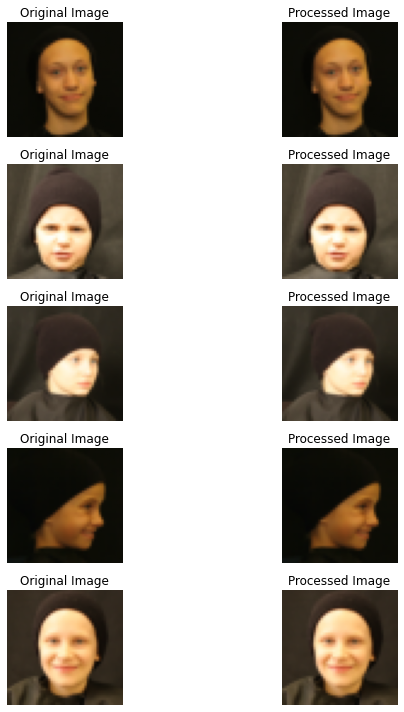

In [40]:
visualize_transformations(df, new_df, dataset_name)

In [41]:
hdf5_file = f"../data/{dataset_name}/{dataset_name}_preprocessed.h5"
image_data = np.stack(new_df["pixels"].values)
label_data = np.array(new_df["emotion"])

In [42]:
def save_preprocessed_data(images, labels, file_path):
    """
    Saves the preprocessed images and labels into an HDF5 file.
    
    Parameters:
    - images: NumPy array of images.
    - labels: NumPy array of labels.
    - file_path: The file path to save the HDF5 file.
    """
    with h5py.File(file_path, "w") as h5f:
        h5f.create_dataset("images", data=images)
        h5f.create_dataset("labels", data=labels)
        
    print(f"Preprocessing complete. Data saved to: {file_path}")

In [43]:
save_preprocessed_data(image_data, label_data, hdf5_file)

Preprocessing complete. Data saved to: ../data/dartmouth/dartmouth_preprocessed.h5
